# 210424 Fix Component 20

In [1]:
const COMPONENT = 20;

In [2]:
include("fix-component-base.jl");

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-13186431300620309202\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-13602548441120221233\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-13186431300620309202\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

,id,ncbi_id,name,rank,parent_id,in_v12,manual_threshold,report,ngenomes,comp_idx,diameter,outgoing,incoming,name_abbr
,Int64,Int64?,String,String?,Int64?,Bool,Float64,Bool,Int64,Int64,Float32,Int64,Int64,SubStri…
1,620,550,Enterobacter cloacae,species,145,1,NaN,1,98,1,0.677811,1,1,cloacae
2,1280,158836,Enterobacter hormaechei,species,145,1,NaN,1,202,2,0.673943,1,1,hormaechei


In [3]:
trees = Dict{String, Any}();

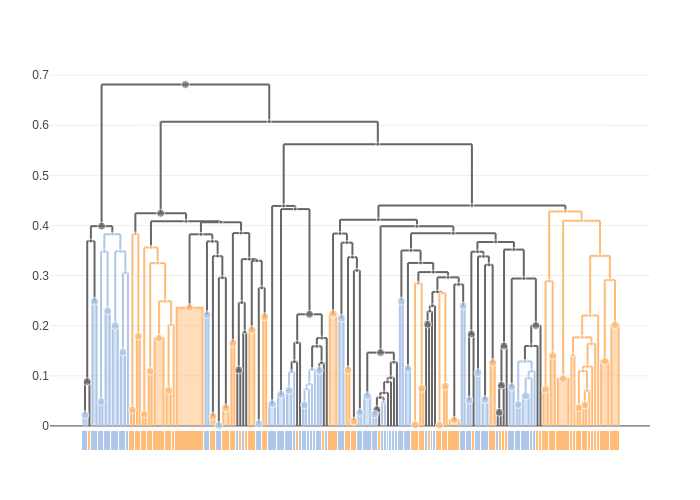

In [4]:
trees["all"] = cluster_annotate(cdata, 1:cdata.ntaxa)
plot(dendrogram(cdata, trees["all"], max_leaves=100))

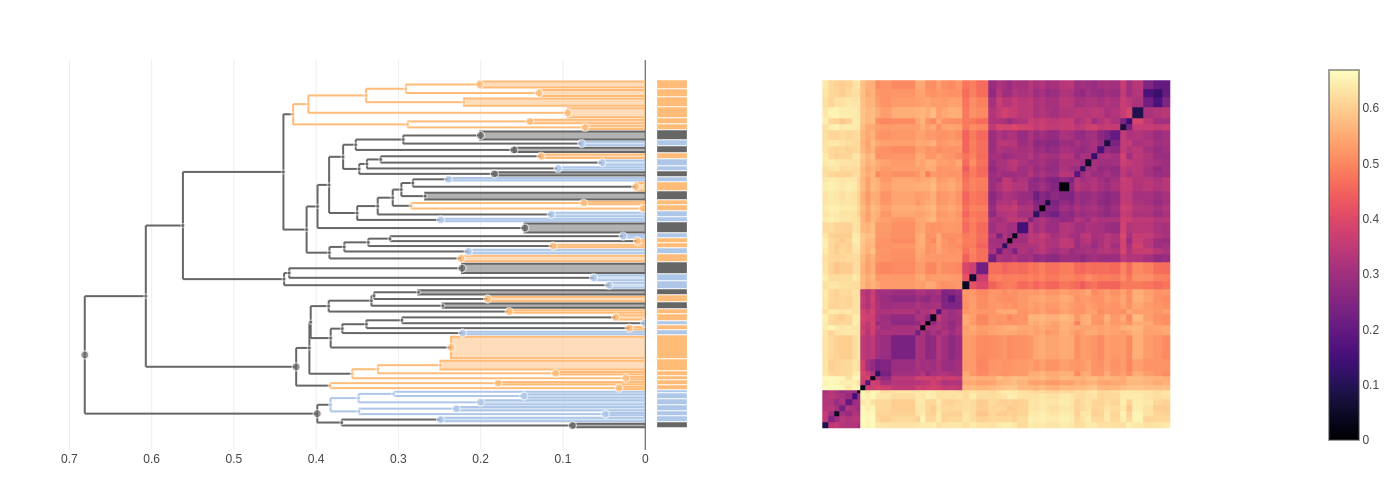

In [5]:
plot(multi_clustermap(cdata, trees["all"], max_leaves=50))

## Attempt to subdivide

Check out the largest subtrees of the combined tree and see how pure they are:

In [6]:
using ClusterAnalysis

In [7]:
subtree_ids = [587, 592, 595, 591, 593]

5-element Array{Int64,1}:
 587
 592
 595
 591
 593

In [8]:
let ta = trees["all"], tree = ta.tree
    for id in subtree_ids
        node = tree.nodes[id]
        println("#$id - $(node.count) genomes")
        leaf_labels = nodeattrs(ta, leaves(tree, id), :class_label)
        
        for (i, ti) in enumerate(ta.attrs[:taxa])
            c = count(==(i), leaf_labels)
            println("\t", c, " ", cdata.taxa[ti, :name_abbr])
        end
    end
end

#587 - 19 genomes
	18 cloacae
	1 hormaechei
#592 - 123 genomes
	8 cloacae
	115 hormaechei
#595 - 25 genomes
	23 cloacae
	2 hormaechei
#591 - 89 genomes
	49 cloacae
	40 hormaechei
#593 - 44 genomes
	0 cloacae
	44 hormaechei


Subtrees 1, 2, 3, and 5 look pretty pure. Zoom into 4 to see if we can further separate:

### Mixed subtree

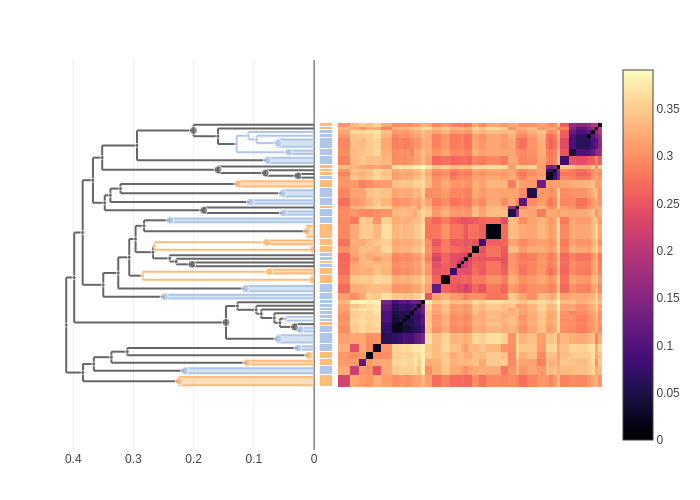

In [9]:
let tree1 = trees["all"]
    tree2, id_map = ClusterAnalysis.get_subtree(tree1, subtree_ids[4])
    leaf_map = id_map[1:tree2.tree.n]
    tree2.attrs[:dmat] = tree1.attrs[:dmat][leaf_map, leaf_map]
    plot(multi_clustermap(cdata, tree2))
end

Doesn't look like much separation is possible. David says to just remove it, but this would remove about half of cloacae genomes. Instead try to pull out the two tight cloacae subtrees. This plot's node IDs are remapped, using the dendrogram of `tree["all"]` above they are 506 and 497.

### Do split

In [10]:
let ta = trees["all"]
    
    split_assignments = Dict(
        1 => [595, 587, 506, 497],  # cloacae
        2 => [592, 593],  # hormaechei
    )
    
    for (ti, ids) in split_assignments
        subgroup_gidxs = map(ids) do id
            node = ta.tree.nodes[id]
            [
                row[:genome_idx] for row in eachrow(nodeattrs(ta, leaves(node)))
                if ta.attrs[:taxa][row[:class_label]] == ti
            ]
        end
        remove_gidxs = setdiff(cdata.genome_idxs[ti], subgroup_gidxs...)
        
        edits.split_taxa[ti] = subgroup_gidxs
        union!(edits.removed_genomes, remove_gidxs)
                        
        lens = length.(subgroup_gidxs)
        println("#", ti, " ", cdata.taxa[ti, :name],
            " ", join(map(length, subgroup_gidxs), "/"),
            " (", length(remove_gidxs), " removed)")
    end
end

#2 Enterobacter hormaechei 115/44 (43 removed)
#1 Enterobacter cloacae 23/18/13/9 (35 removed)


## Touch up subgroups

In [11]:
check_edit_progress(edits)

#6 hormaechei subgroup 2
	=> #3 cloacae subgroup 3
	=> #4 cloacae subgroup 4


In [12]:
cdata2 = apply_edits(edits)
edits2 = DatabaseEdits(cdata2);

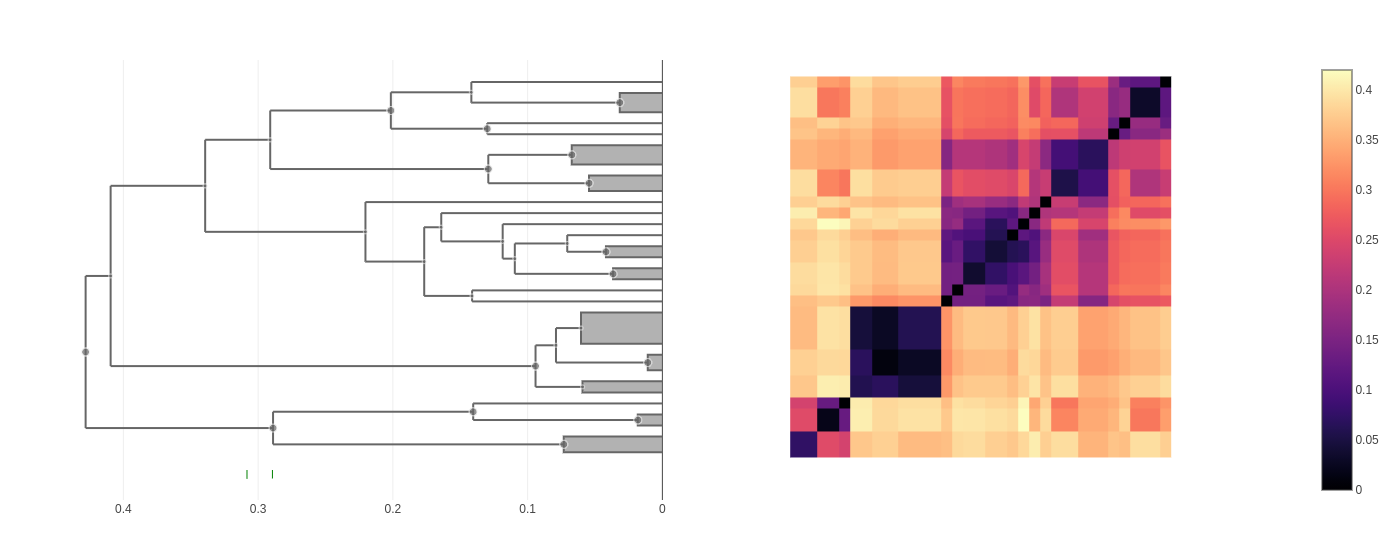

In [13]:
plot(clustermap(cdata2, "hormaechei subgroup 2"))

In [14]:
set_threshold!(edits2, "hormaechei subgroup 2", .25)

0.25

## Finish

In [15]:
complete_edits(edits, edits2)

,index,name,ngenomes,initial_diameter,taxon_removed,removed_genomes,split,manual_threshold,final_diameter
,Int64,SubStri…,Int64,Float32,Bool,Int64,String,Missing,String
1,1,cloacae,98,0.677811,0,35,"23, 18, 13, 9",missing,"0.4379, 0.3987, 0.1463, 0.1286"
2,2,hormaechei,202,0.673943,0,43,"115, 44",missing,"0.4243, 0.4280"
